# Relationship Between Political Party Performance and Voter Turnout Across Levels of Government
### Abigail Wang, Andrei Ivanov, Nico Huberty, Penny Wang

## Introduction


In [48]:
# import libraries
import pandas as pd
import matplotlib.pyplot as plt 
import statistics as stats
import numpy as np 
import os

#presidential
pres_county = pd.read_csv("data/president_county_candidate.csv")

#senate
senate_county = pd.read_csv("data/senate_county.csv")
senate_county_candidate = pd.read_csv("data/senate_county_candidate.csv")
senate_state = pd.read_csv("data/senate_state.csv")

#population
state_pop = pd.read_csv("data/state_population.csv") 
#taken from https://data.census.gov/table/DECENNIALCD1182020.P1?q=Population+Total
county_pop = pd.read_excel("data/county_pop.xlsx") 
#taken from https://www.census.gov/data/tables/time-series/demo/popest/2020s-counties-total.html

### Data Used
In this project, we used several election-related datasets to analyze county- and state-level voting patterns in the United States of America. We used the president_county_candidate table (32178 rows), in which each row shows the total number of votes received by a presidential candidate within an individual county in a state, as well as the party of the candidate and whether or not he or she won; the senate_county table (3583 rows), where each row shows Senate votes by county and the percent of votes; the senate_county_candidate table (14126 rows), in which each row shows the state, county, candidate, party, and total vote number; and the state_population (organized by column: 50 states, District of Columbia and Puerto Rico) and county_population (3143 rows) tables, which provide population counts at state at county level. We imported pandas, matplotlib, statistics, numpy, and os. These datasets together allow us to look at how population characteristics relate to presidential and Senate election outcomes at county and state level.

Cleaning State and County Pop

In [49]:
state_pop = state_pop.T
state_pop.columns = state_pop.iloc[0]
state_pop = state_pop.drop(state_pop.index[0]).reset_index()
state_pop.columns = ['state', 'population']
state_pop['population'] = state_pop['population'].str.replace(',', '').astype(int)

In [50]:
county_pop_cols= county_pop.columns
county_pop_cols = county_pop_cols[:2] 
#only keep first two cols
county_pop = county_pop[4:] 
#remove excess rows
county_pop = county_pop[county_pop_cols]
county_pop = county_pop.rename(columns={'table with row headers in column A and column headers in rows 3 through 4 (leading dots indicate sub-parts)':'county', 'Unnamed: 1':'population'})
county_pop = county_pop.dropna()

In [51]:
county_pop['county'] = county_pop['county'].str.lstrip('.')
county_pop[['county', 'state']] = county_pop['county'].str.split(',', expand=True)
county_pop['state'] = county_pop['state'].str.strip()
county_pop['county'] = county_pop['county'].str.strip()
county_pop['county'] = county_pop['county'].str.lower()
county_pop['state'] = county_pop['state'].str.lower()
county_pop['population'] = county_pop['population'].astype('int')

### President and Voter Share

In [52]:
pres_county['county'] = pres_county['county'].str.lower()
pres_county['state'] = pres_county['state'].str.lower()
pres_county = pres_county[(pres_county['party'] == 'DEM') | (pres_county['party'] == 'REP')]

In [53]:
pres_county = pres_county.merge(county_pop, on=['county', 'state'], how='left')
pres_county = pres_county.dropna()

In [54]:
pres_county = pres_county[pres_county['county'] != 'district of columbia']
pres_county['county_total_votes'] = pres_county.groupby(['state', 'county'])['total_votes'].transform('sum')
pres_county['vote_share'] = pres_county['total_votes'] / pres_county['county_total_votes']

In [55]:
pres_county['turnout'] = pres_county['county_total_votes'] / pres_county['population']
pres_county = pres_county[pres_county['won'] == True]

The descriptive statistics for the 3,043 counties in this dataset reveal large variation in population size and total votes. County populations range from 65 residents to over 10 million, with a mean of ~103,000, but an extremely large standard deviation of ~337,000, meaning most counties are smaller with some very large outliers. Total votes follow a similar pattern. Vote share ranges from barely over 0.5 to over 0.96, with the middle half of counties falling between ~0.616 and ~0.791, showing that levels of support in counties vary considerably. Turnout ranged from just ~0.162 to more than 0.98 of the population; the mean turnout was about 0.487, and the standard deviation was about 0.08, demonstrating moderate variation with some extreme outliers.

In [56]:
pres_county.describe()

,total_votes,population,county_total_votes,vote_share,turnout
count,3.043000e+03,3.043000e+03,3.043000e+03,3043.000000,3043.000000
mean,3.094824e+04,1.034345e+05,4.828328e+04,0.703882,0.486714
std,9.726042e+04,3.373890e+05,1.470081e+05,0.108195,0.081826
min,6.000000e+01,6.500000e+01,6.400000e+01,0.500121,0.161668
25%,3.777000e+03,1.081800e+04,5.183000e+03,0.615371,0.433645
50%,8.336000e+03,2.531600e+04,1.194900e+04,0.708987,0.488233
75%,2.096400e+04,6.665150e+04,3.155400e+04,0.791505,0.538552
max,3.028885e+06,1.001740e+07,4.174415e+06,0.968864,0.984615


Plotting Relationships

Figure 1. Vote Share vs. Voter Turnout by Party (Presidential Elections)

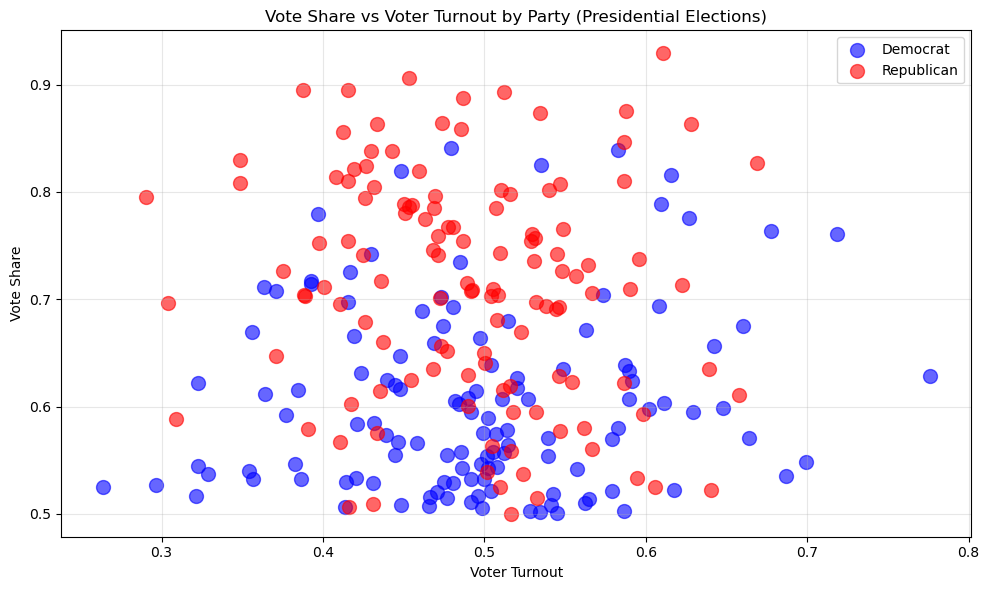

In [57]:
plt.figure(figsize=(10, 6))

dem_data = pres_county[pres_county['party'] == 'DEM'].sample(n=125, random_state=42)
rep_data = pres_county[pres_county['party'] == 'REP'].sample(n=125, random_state=42)

plt.scatter(dem_data['turnout'], dem_data['vote_share'], c='blue', label='Democrat', alpha=0.6, s=100)
plt.scatter(rep_data['turnout'], rep_data['vote_share'], c='red', label='Republican', alpha=0.6, s=100)

plt.xlabel('Voter Turnout')
plt.ylabel('Vote Share')
plt.title('Vote Share vs Voter Turnout by Party (Presidential Elections)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

Figure 2. Average Voter Turnout by Party (Counties Won)

C:\Users\pompo\AppData\Local\Temp\ipykernel_21904\1150895156.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  avg_turnout_by_party = pres_county.groupby('party').apply(lambda x: np.average(x['turnout'], weights=x['population']))


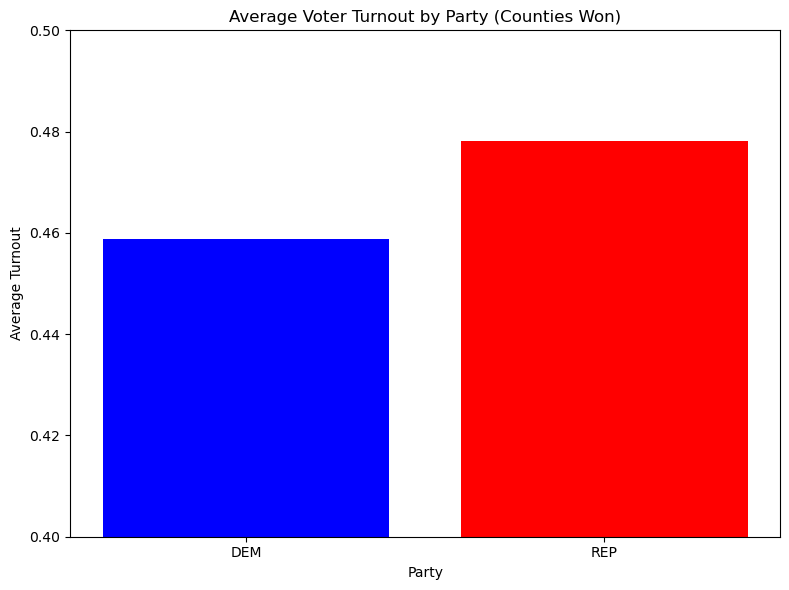

In [58]:
#bar chart of average turnout for rep wins vs dem wins
avg_turnout_by_party = pres_county.groupby('party').apply(lambda x: np.average(x['turnout'], weights=x['population']))

plt.figure(figsize=(8, 6))
plt.bar(avg_turnout_by_party.index, avg_turnout_by_party.values, color=['blue', 'red'])
plt.xlabel('Party')
plt.ylabel('Average Turnout')
plt.title('Average Voter Turnout by Party (Counties Won)')
plt.ylim(0.4, 0.5)
plt.tight_layout()
plt.show()

In [59]:
pres_county['margin_of_victory'] = pres_county['vote_share'] - (1-pres_county['vote_share'])
dem_data = pres_county[pres_county['party'] == 'DEM']
rep_data = pres_county[pres_county['party'] == 'REP']

In [60]:
sampled_data = pres_county.sample(n=500, random_state=26)
dem_data = sampled_data[sampled_data['party'] == 'DEM']
rep_data = sampled_data[sampled_data['party'] == 'REP']

Figure 3. Voter Turnout vs. County Population (Presidential Elections)

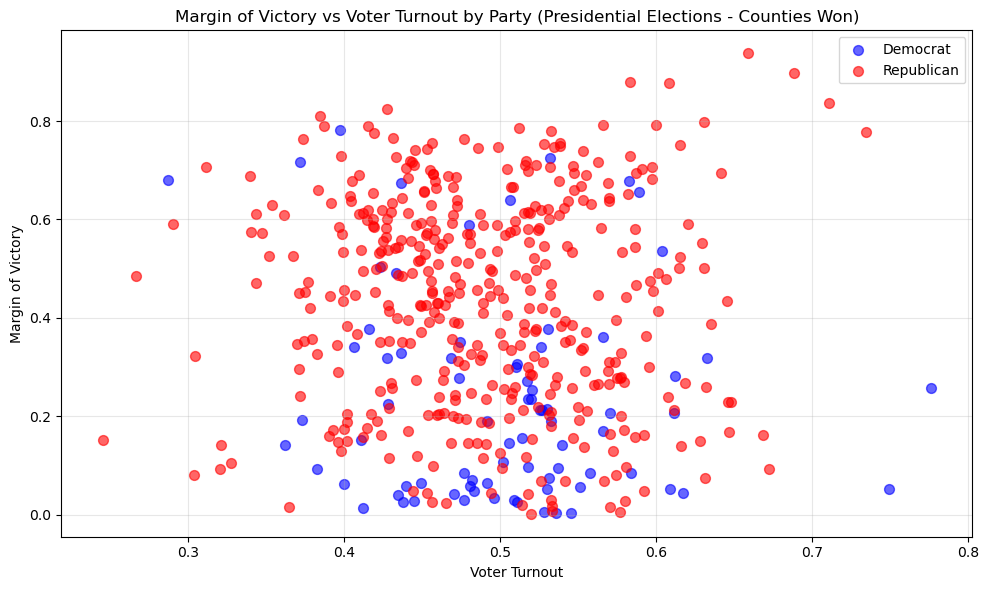

In [61]:
plt.figure(figsize=(10, 6))

plt.scatter(dem_data['turnout'], dem_data['margin_of_victory'], c='blue', label='Democrat', alpha=0.6, s=50)
plt.scatter(rep_data['turnout'], rep_data['margin_of_victory'], c='red', label='Republican', alpha=0.6, s=50)

plt.xlabel('Voter Turnout')
plt.ylabel('Margin of Victory')
plt.title('Margin of Victory vs Voter Turnout by Party (Presidential Elections - Counties Won)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

Fig. 4 Margin of Victory vs. Voter Turnout by Party (Presidential Elections – Counties Won)

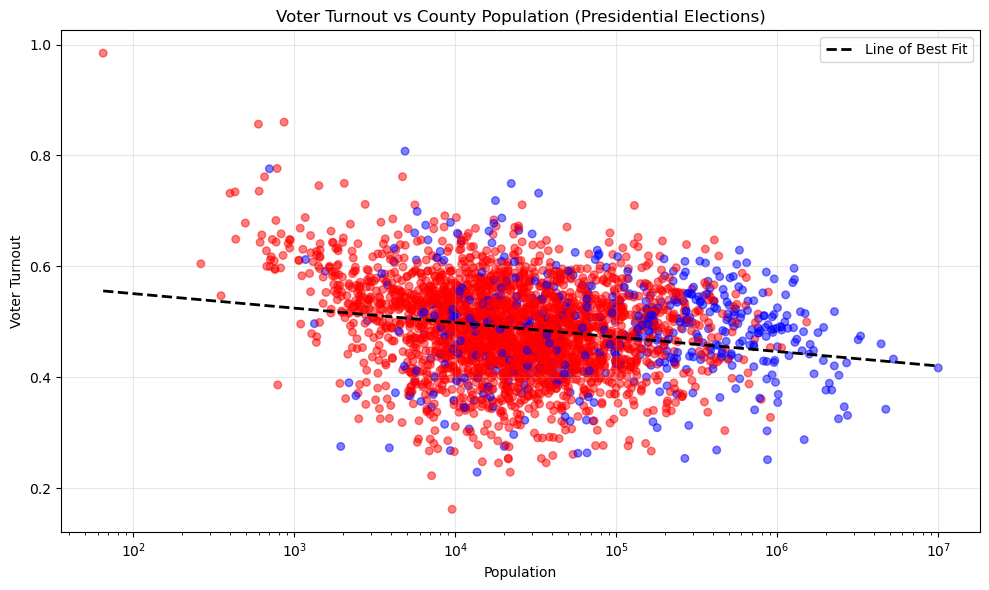

In [62]:
plt.figure(figsize=(10, 6))
plt.scatter(pres_county['population'], pres_county['turnout'], c=pres_county['party'].map({'DEM': 'blue', 'REP': 'red'}), alpha=0.5, s=30)
log_pop = np.log10(pres_county['population'])

#line of best fit
coefficients = np.polyfit(log_pop, pres_county['turnout'], 1)
poly = np.poly1d(coefficients)
x_line = np.linspace(log_pop.min(), log_pop.max(), 100)
y_line = poly(x_line)

plt.plot(10**x_line, y_line, color='black', linestyle='--', linewidth=2, label='Line of Best Fit')
plt.xlabel('Population')
plt.ylabel('Voter Turnout')
plt.title('Voter Turnout vs County Population (Presidential Elections)')
plt.xscale('log')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### Senate Vote Share

In [63]:
senate_county_candidate = senate_county_candidate[(senate_county_candidate['party'] == 'REP') | (senate_county_candidate['party'] == 'DEM')]
vote_state = senate_county_candidate.groupby(['state', 'party'])['total_votes'].sum().reset_index()
vote_state = vote_state.rename(columns={'total_votes': 'candidate_votes'})

vote_state = vote_state.merge(senate_state, how='right', on=['state'])
vote_state = vote_state.merge(state_pop, how='right', on=['state'])

vote_state['vote_share'] = round(vote_state['candidate_votes'] / vote_state['total_votes'], 3)
vote_state

,state,party,candidate_votes,total_votes,population,vote_share
0,Alabama,DEM,595943.0,2316445.0,5024279,0.257
1,Alabama,REP,199246.0,2316445.0,5024279,0.086
2,Alaska,DEM,86606.0,354587.0,733391,0.244
3,Alaska,REP,43218.0,354587.0,733391,0.122
4,Arizona,DEM,259629.0,3355317.0,7151502,0.077
...,...,...,...,...,...,...
79,West Virginia,DEM,210309.0,778918.0,1793716,0.270
80,Wisconsin,NaN,NaN,NaN,5893718,NaN
81,Wyoming,DEM,63736.0,270866.0,576851,0.235
82,Wyoming,REP,5370.0,270866.0,576851,0.020


In [64]:
vote_state['turn_out'] = round(vote_state['total_votes'] / vote_state['population'], 3)


The descriptive statistics for the 34 states in this table show substantial variation in population, total votes, and total candidate votes. Populations range from ~576,000 to over 29 million, with a mean of 5.27 million. Total votes cast reflect this large variation in state population, ranging from ~271,000 to more than 11 million, with a mean of 2.8 million. Vote share varies widely, from a minimum of 0.072 to a maximum of 0.5. Turnout is more stable across states, with the middle 50% of states falling between ~0.45 and ~0.52 proportion. 

In [65]:
vote_state.describe()

,candidate_votes,total_votes,population,vote_share,turn_out
count,6.600000e+01,6.600000e+01,8.400000e+01,66.000000,66.000000
mean,5.570670e+05,2.639212e+06,6.244482e+06,0.196227,0.487152
std,6.168936e+05,2.289662e+06,6.705847e+06,0.109302,0.051213
min,2.773000e+03,2.708660e+05,5.768510e+05,0.007000,0.382000
25%,1.374128e+05,8.290938e+05,1.827758e+06,0.106750,0.459500
50%,2.616430e+05,2.134667e+06,4.581796e+06,0.189500,0.474000
75%,7.083740e+05,3.564136e+06,7.936809e+06,0.266750,0.524000
max,2.456123e+06,1.114404e+07,3.953822e+07,0.500000,0.601000


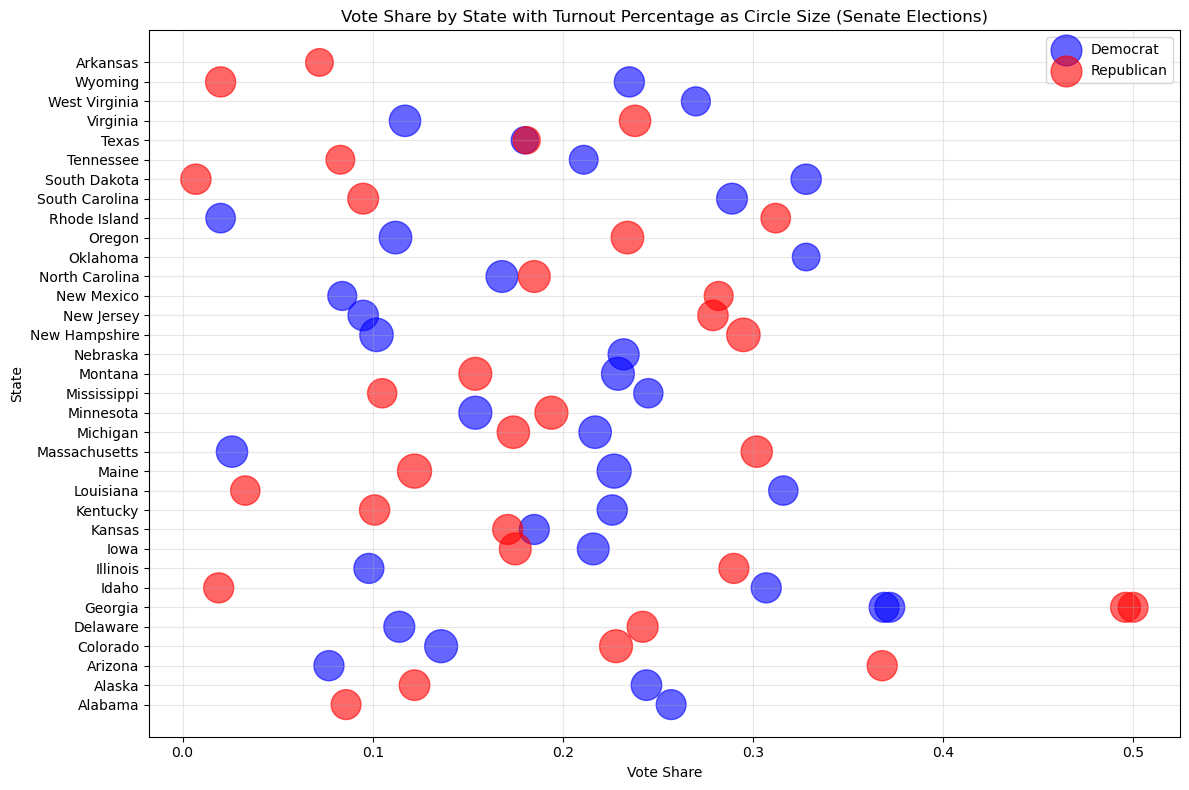

In [66]:
plt.figure(figsize=(12, 8))

dem_data = vote_state[vote_state['party'] == 'DEM']
rep_data = vote_state[vote_state['party'] == 'REP']

dem_sizes = dem_data['turn_out'] * 1000
rep_sizes = rep_data['turn_out'] * 1000

plt.scatter(dem_data['vote_share'], dem_data['state'], s=dem_sizes, c='blue', alpha=0.6, label='Democrat')
plt.scatter(rep_data['vote_share'], rep_data['state'], s=rep_sizes, c='red', alpha=0.6, label='Republican')

plt.xlabel('Vote Share')
plt.ylabel('State')
plt.title('Vote Share by State with Turnout Percentage as Circle Size (Senate Elections)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

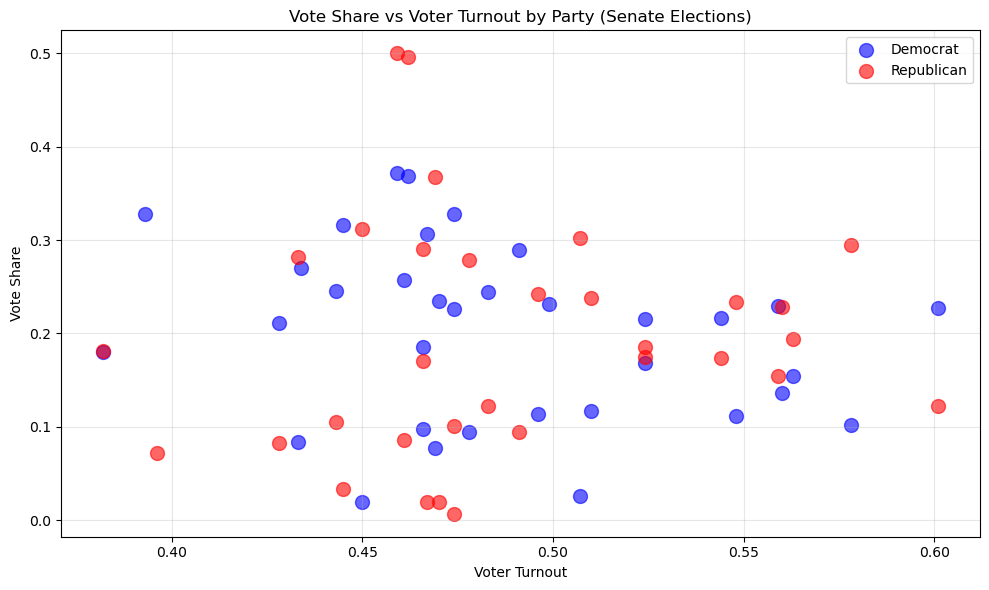

In [67]:
#scatter plot for vote share and turn out, color of the dot depends on party
plt.figure(figsize=(10, 6))

dem_data = vote_state[vote_state['party'] == 'DEM']
rep_data = vote_state[vote_state['party'] == 'REP']

plt.scatter(dem_data['turn_out'], dem_data['vote_share'], c='blue', label='Democrat', alpha=0.6, s=100)
plt.scatter(rep_data['turn_out'], rep_data['vote_share'], c='red', label='Republican', alpha=0.6, s=100)

plt.xlabel('Voter Turnout')
plt.ylabel('Vote Share')
plt.title('Vote Share vs Voter Turnout by Party (Senate Elections)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


In [68]:
vote_state = vote_state.loc[vote_state.groupby(['state'])['vote_share'].idxmax()]

KeyError: '[nan] not in index'

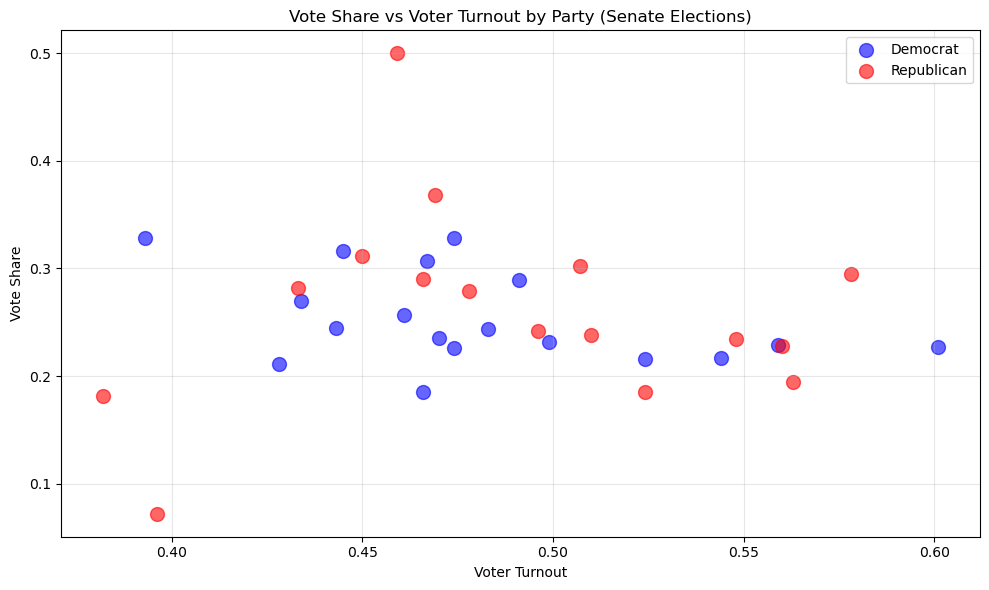

In [ ]:
plt.figure(figsize=(10, 6))

dem_data = vote_state[vote_state['party'] == 'DEM']
rep_data = vote_state[vote_state['party'] == 'REP']

plt.scatter(dem_data['turn_out'], dem_data['vote_share'], c='blue', label='Democrat', alpha=0.6, s=100)
plt.scatter(rep_data['turn_out'], rep_data['vote_share'], c='red', label='Republican', alpha=0.6, s=100)

plt.xlabel('Voter Turnout')
plt.ylabel('Vote Share')
plt.title('Vote Share vs Voter Turnout by Party (Senate Elections)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

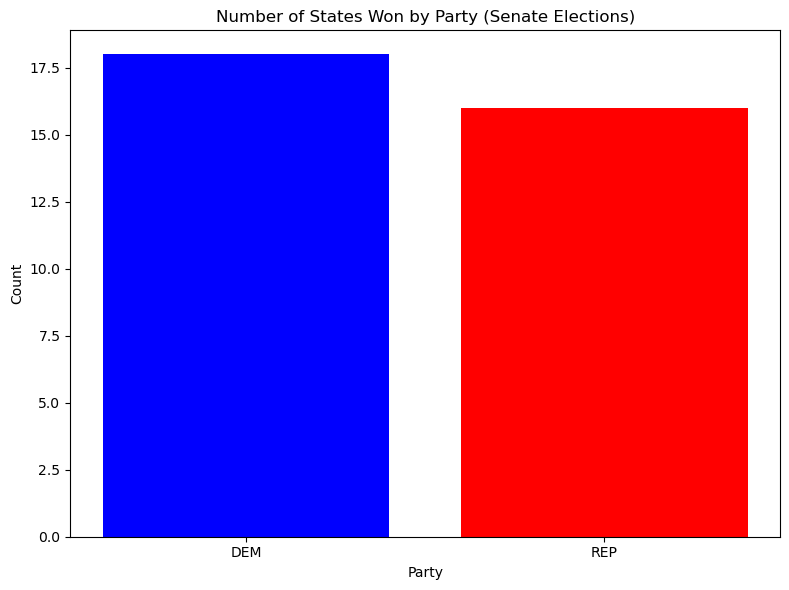

In [ ]:
party_counts = vote_state['party'].value_counts()

plt.figure(figsize=(8, 6))
plt.bar(party_counts.index, party_counts.values, color=['blue', 'red'])
plt.xlabel('Party')
plt.ylabel('Count')
plt.title('Number of States Won by Party (Senate Elections)')
plt.tight_layout()
plt.show()